In [1]:
import Pkg
Pkg.activate("../../../.")
include("../../../LogLoss/RealRealHighDimension.jl")
include("../../../Interpolation/ForecastingMainNew.jl");
using JLD2
using DataFrames

  Activating project at `~/Desktop/QuantumInspiredML`


In [10]:
svpath_ns = "../../../Data/simple-synthetic/mps-saves/new_legendre_ns_d12_chi60.jld2";
dloc =  "../../../Data/simple-synthetic/datasets/noisy_trendy_sine_eta_03_m_3_tau_20.jld2";

In [11]:
f = jldopen(dloc, "r")
    X_train = read(f, "X_train")
    y_train = read(f, "y_train")
    X_test = read(f, "X_test")
    y_test = read(f, "y_test")
close(f)

In [12]:
f = jldopen(svpath_ns, "r")
    mps_ns = read(f, "mps")
    opts_ns = read(f, "opts")
close(f)
opts_ns, _... = safe_options(opts_ns, nothing, nothing)

fc_ns = load_forecasting_info_variables(mps_ns, X_train, y_train, X_test, y_test, opts_ns);


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 300 training samples and 200 testing samples.
 - 1 class(es) was detected. Slicing MPS into individual states...
 - Time independent encoding - Legendre_No_Norm - detected.
 - d = 12, chi_max = 60

 Created 1 forecastable struct(s) containing class-wise mps and test samples.


In [272]:
class = 0
interp_sites = collect(6:95)
nn_maes = []
mps_maes = []
for i=1:size(X_test, 1)
    println("$i")
    stats, p1_ns = any_interpolate_median(fc_ns, class, i, interp_sites; NN_baseline=true, 
    X_train=X_train, y_train=y_train, n_baselines=1, plot_fits=true)
    push!(nn_maes, stats[:NN_MAE])
    push!(mps_maes, stats[:MAE])
end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175


┌ Warning: Test set has a value more than 1% above upper bound after train normalization!
└ @ Main /Users/joshua/Desktop/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:519


176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


In [273]:
nn_mean_mae_50pt = mean(nn_maes)
mps_mean_mae_50pt = mean(mps_maes)
println(nn_mean_mae_50pt)
println(mps_mean_mae_50pt)

0.18307583771175392
0.14757592107895381


In [274]:
reverse(sortperm(nn_maes - mps_maes))[1:10]

10-element Vector{Int64}:
  69
  21
 106
   6
 108
  59
 127
  45
   3
  81

In [21]:
interp_sites = collect(25:75)
stats, p1_ns = any_interpolate_median(fc_ns, 0, 34, interp_sites; NN_baseline=false, 
    X_train=X_train, y_train=y_train, n_baselines=1, plot_fits=true, wmad=true)

(Dict(:MAE => 0.2964656137422149), Plots.Plot{Plots.GRBackend}[Plot{Plots.GRBackend() n=3}])

╭────────┬──────────╮
│ Metric │    Value │
├────────┼──────────┤
│    MAE │ 0.296466 │
╰────────┴──────────╯


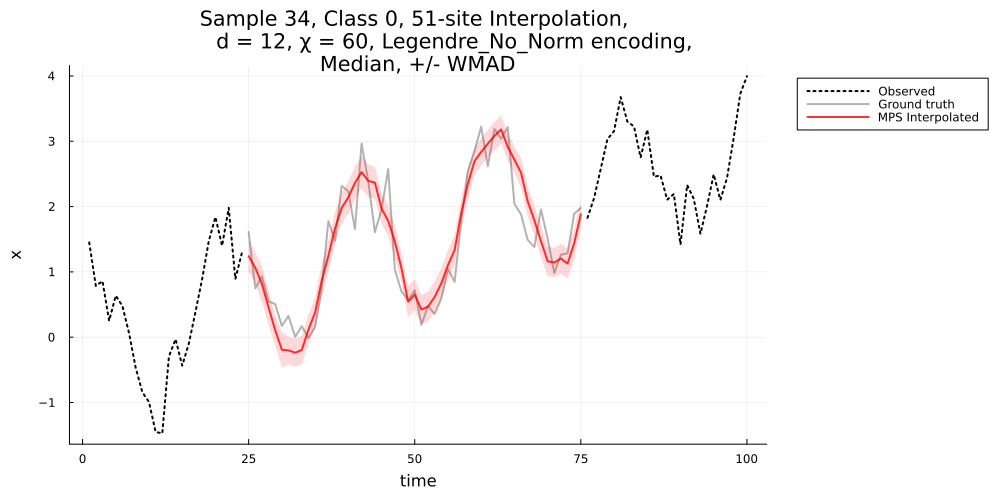

In [22]:
pretty_table(stats; header=["Metric", "Value"], header_crayon= crayon"yellow bold", tf = tf_unicode_rounded);
plot(p1_ns...)

# Benchmark

Successively decreasing windows, starting at 94% missing data (94pt window) and decreasing by a fixed amount each time.

In [277]:
windows = [(i, j) for (i, j) in zip(6:2:95, 95:-2:6) if j >= i]

23-element Vector{Tuple{Int64, Int64}}:
 (6, 95)
 (8, 93)
 (10, 91)
 (12, 89)
 (14, 87)
 (16, 85)
 (18, 83)
 (20, 81)
 (22, 79)
 (24, 77)
 ⋮
 (34, 67)
 (36, 65)
 (38, 63)
 (40, 61)
 (42, 59)
 (44, 57)
 (46, 55)
 (48, 53)
 (50, 51)

In [262]:
nn_mean_mae_per_window = []
nn_std_mae_per_window = []
mps_mean_mae_per_window = []
mps_std_mae_per_window = []
for w in windows
    println("Evaluating window: $w")
    lower, upper = w
    nn_maes = []
    mps_maes = []
    interp_sites = collect(lower:upper)
    for i=1:size(X_test, 1)
        stats, p1_ns = any_interpolate_median(fc_ns, 0, i, interp_sites; NN_baseline=true, 
        X_train=X_train, y_train=y_train, n_baselines=1, plot_fits=false)
        push!(nn_maes, stats[:NN_MAE])
        push!(mps_maes, stats[:MAE])
    end
    # take the mean and std
    mps_mean, mps_std = mean(mps_maes), std(mps_maes)
    nn_mean, nn_std = mean(nn_maes), std(nn_maes)

    push!(nn_mean_mae_per_window, nn_mean)
    push!(nn_std_mae_per_window, nn_std)
    push!(mps_mean_mae_per_window, mps_mean)
    push!(mps_std_mae_per_window, mps_std)

    # print stats
    println("Window: $w | MPS mean: $mps_mean MPS std: $mps_std | 1NN mean: $nn_mean | 1NN std: $nn_std")
end

Evaluating window: (6, 95)


┌ Warning: Test set has a value more than 1% above upper bound after train normalization!
└ @ Main /Users/joshua/Desktop/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:519


Window: (6, 95) | MPS mean: 0.1471679063184223 MPS std: 0.021085514743984037 | 1NN mean: 0.18307583771175392 | 1NN std: 0.022699528704218885
Evaluating window: (8, 93)


┌ Warning: Test set has a value more than 1% above upper bound after train normalization!
└ @ Main /Users/joshua/Desktop/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:519


Window: (8, 93) | MPS mean: 0.14416334241050455 MPS std: 0.01913834234740079 | 1NN mean: 0.17895409999750192 | 1NN std: 0.02041536799900409
Evaluating window: (10, 91)


┌ Warning: Test set has a value more than 1% above upper bound after train normalization!
└ @ Main /Users/joshua/Desktop/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:519


Window: (10, 91) | MPS mean: 0.1426739667282034 MPS std: 0.017667640871316764 | 1NN mean: 0.17786768620955237 | 1NN std: 0.019920898709180207
Evaluating window: (12, 89)


┌ Warning: Test set has a value more than 1% above upper bound after train normalization!
└ @ Main /Users/joshua/Desktop/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:519


Window: (12, 89) | MPS mean: 0.14097500251580938 MPS std: 0.015944261004243683 | 1NN mean: 0.17761791766049648 | 1NN std: 0.018531879122963835
Evaluating window: (14, 87)


┌ Warning: Test set has a value more than 1% above upper bound after train normalization!
└ @ Main /Users/joshua/Desktop/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:519


Window: (14, 87) | MPS mean: 0.14054284882940152 MPS std: 0.015501636278684243 | 1NN mean: 0.17749846646788872 | 1NN std: 0.018579031017810412
Evaluating window: (16, 85)


┌ Warning: Test set has a value more than 1% above upper bound after train normalization!
└ @ Main /Users/joshua/Desktop/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:519


Window: (16, 85) | MPS mean: 0.1406308539019777 MPS std: 0.015597024563846986 | 1NN mean: 0.17824234567466404 | 1NN std: 0.018812232742156033
Evaluating window: (18, 83)


┌ Warning: Test set has a value more than 1% above upper bound after train normalization!
└ @ Main /Users/joshua/Desktop/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:519


Window: (18, 83) | MPS mean: 0.14090510148243557 MPS std: 0.017006959606655145 | 1NN mean: 0.176667534314378 | 1NN std: 0.01978504057650742
Evaluating window: (20, 81)


┌ Warning: Test set has a value more than 1% above upper bound after train normalization!
└ @ Main /Users/joshua/Desktop/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:519


Window: (20, 81) | MPS mean: 0.14015933991010993 MPS std: 0.016706831028083433 | 1NN mean: 0.1764800105000916 | 1NN std: 0.020794716026790314
Evaluating window: (22, 79)


┌ Warning: Test set has a value more than 1% above upper bound after train normalization!
└ @ Main /Users/joshua/Desktop/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:519


Window: (22, 79) | MPS mean: 0.13962143304199073 MPS std: 0.016573721742069714 | 1NN mean: 0.17469985323192103 | 1NN std: 0.020072436164318745
Evaluating window: (24, 77)


┌ Warning: Test set has a value more than 1% above upper bound after train normalization!
└ @ Main /Users/joshua/Desktop/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:519


Window: (24, 77) | MPS mean: 0.14028735514621404 MPS std: 0.016882434206784255 | 1NN mean: 0.17342494839201641 | 1NN std: 0.01863977244573442
Evaluating window: (26, 75)


┌ Warning: Test set has a value more than 1% above upper bound after train normalization!
└ @ Main /Users/joshua/Desktop/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:519


Window: (26, 75) | MPS mean: 0.14049150089985232 MPS std: 0.018367345025556765 | 1NN mean: 0.17450037433382642 | 1NN std: 0.018923427628466157
Evaluating window: (28, 73)


┌ Warning: Test set has a value more than 1% above upper bound after train normalization!
└ @ Main /Users/joshua/Desktop/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:519


Window: (28, 73) | MPS mean: 0.14020033900639592 MPS std: 0.018949032444192316 | 1NN mean: 0.1740276891523324 | 1NN std: 0.02014689888160652
Evaluating window: (30, 71)


┌ Warning: Test set has a value more than 1% above upper bound after train normalization!
└ @ Main /Users/joshua/Desktop/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:519


Window: (30, 71) | MPS mean: 0.14104716659706795 MPS std: 0.019840511115910245 | 1NN mean: 0.17521026063863424 | 1NN std: 0.021286828360836653
Evaluating window: (32, 69)


┌ Warning: Test set has a value more than 1% above upper bound after train normalization!
└ @ Main /Users/joshua/Desktop/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:519


Window: (32, 69) | MPS mean: 0.1403996674390841 MPS std: 0.019463932524645657 | 1NN mean: 0.17452737595412504 | 1NN std: 0.022468706906877974
Evaluating window: (34, 67)


┌ Warning: Test set has a value more than 1% above upper bound after train normalization!
└ @ Main /Users/joshua/Desktop/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:519


Window: (34, 67) | MPS mean: 0.14097690206259214 MPS std: 0.019874984265737652 | 1NN mean: 0.17651432519140325 | 1NN std: 0.023316204774466116
Evaluating window: (36, 65)


┌ Warning: Test set has a value more than 1% above upper bound after train normalization!
└ @ Main /Users/joshua/Desktop/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:519


Window: (36, 65) | MPS mean: 0.14163938016304123 MPS std: 0.020365463644689635 | 1NN mean: 0.17443232334496847 | 1NN std: 0.023482657358505177
Evaluating window: (38, 63)


┌ Warning: Test set has a value more than 1% above upper bound after train normalization!
└ @ Main /Users/joshua/Desktop/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:519


Window: (38, 63) | MPS mean: 0.14204031892639257 MPS std: 0.02120237375303761 | 1NN mean: 0.17552903161032224 | 1NN std: 0.026656226101394374
Evaluating window: (40, 61)


┌ Warning: Test set has a value more than 1% above upper bound after train normalization!
└ @ Main /Users/joshua/Desktop/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:519


Window: (40, 61) | MPS mean: 0.14279200097079467 MPS std: 0.023358391788159218 | 1NN mean: 0.175603938614539 | 1NN std: 0.02798896342073657
Evaluating window: (42, 59)


┌ Warning: Test set has a value more than 1% above upper bound after train normalization!
└ @ Main /Users/joshua/Desktop/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:519


Window: (42, 59) | MPS mean: 0.14236880897531465 MPS std: 0.025575693792354356 | 1NN mean: 0.17351759763157212 | 1NN std: 0.03368775843160029
Evaluating window: (44, 57)


┌ Warning: Test set has a value more than 1% above upper bound after train normalization!
└ @ Main /Users/joshua/Desktop/QuantumInspiredML/Interpolation/ForecastingMainNew.jl:519


Window: (44, 57) | MPS mean: 0.14210268163923512 MPS std: 0.029764098746736706 | 1NN mean: 0.17434839391288479 | 1NN std: 0.03695485940257365
Evaluating window: (46, 55)


InterruptException: InterruptException:

In [194]:
nn_mean_mae_per_window

23-element Vector{Any}:
 0.35790557889811275
 0.3553511297439703
 0.3524952396939649
 0.3493691533040835
 0.3478677790671753
 0.35083486013634313
 0.35093528662138695
 0.3509951007447309
 0.3499237353582311
 0.3482334766874515
 ⋮
 0.354472102361024
 0.3497596793240134
 0.35111805574918614
 0.3541740111365817
 0.34695701314944766
 0.3514294381619342
 0.3469383469618975
 0.35039925015306317
 0.32286813210777593

In [203]:
windows

23-element Vector{Tuple{Int64, Int64}}:
 (6, 95)
 (8, 93)
 (10, 91)
 (12, 89)
 (14, 87)
 (16, 85)
 (18, 83)
 (20, 81)
 (22, 79)
 (24, 77)
 ⋮
 (34, 67)
 (36, 65)
 (38, 63)
 (40, 61)
 (42, 59)
 (44, 57)
 (46, 55)
 (48, 53)
 (50, 51)

In [206]:
length(collect(6:95))

90

In [209]:
xvals = [length(collect(lower: upper)) for (lower, upper) in windows]

23-element Vector{Int64}:
 90
 86
 82
 78
 74
 70
 66
 62
 58
 54
  ⋮
 34
 30
 26
 22
 18
 14
 10
  6
  2

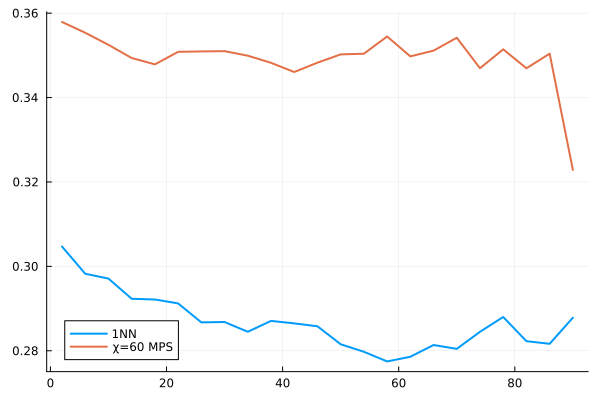

In [212]:
plot(reverse(xvals), mps_mean_mae_per_window, label="1NN", lw=2)
plot!(reverse(xvals), nn_mean_mae_per_window, label="χ=60 MPS", lw=2)